In [1]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt 
from PIL import Image
import imutils

['image1.jpeg', 'image2.jpeg', 'image3.jpeg']


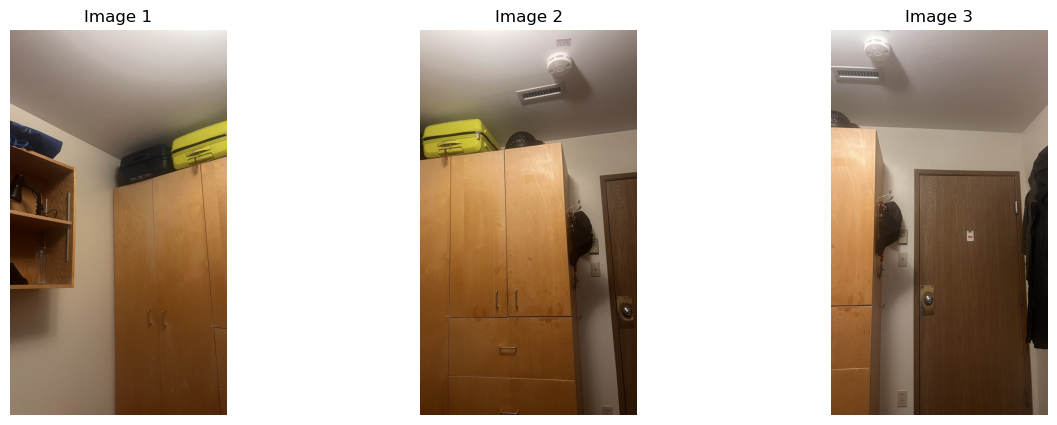

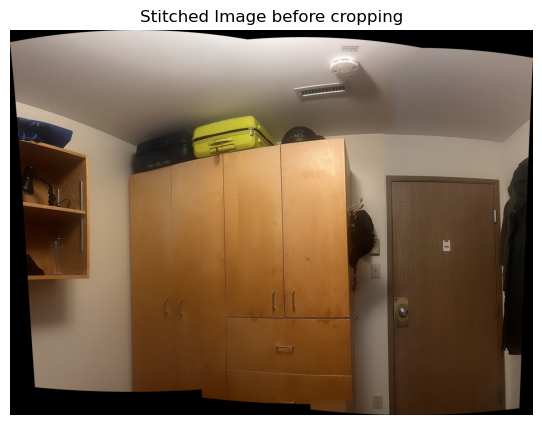

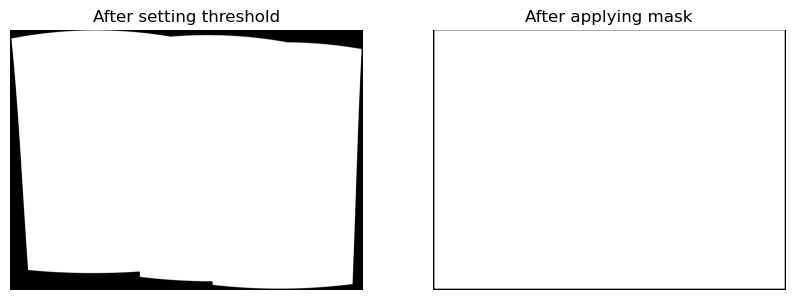

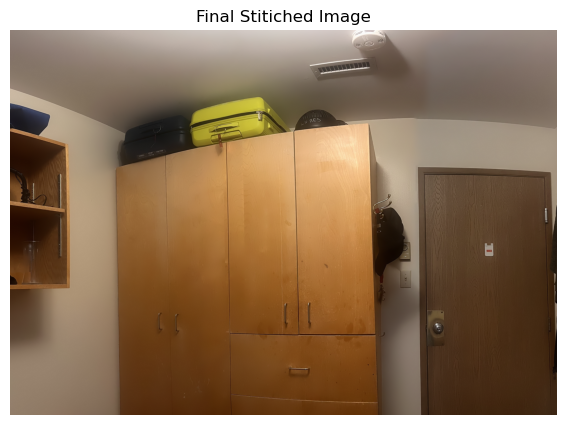

In [6]:
# Path to the folder containing your images
input_Folder = 'InputImages'

# Extracts only jpg, jpeg or png images from the given directory
images_In_Folder = images_In_Folder = [f for f in os.listdir(input_Folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Creating subplot to display the input images extracted from the folder
total_Images = len(images_In_Folder)
fig, axs = plt.subplots(1, total_Images, figsize=(5 * total_Images, 5))

# Array declaration to store the input images
image_Array = []

# Iterate the images, display and store it in the array
for i, image_file in enumerate(images_In_Folder):
    path_Of_Image = os.path.join(input_Folder, image_file)
    image = matplotlib.image.imread(path_Of_Image)
    axs[i].imshow(image)
    axs[i].set_title(f'Image {i+1}')
    axs[i].axis('off')
    image_Array.append(image)
    
print(images_In_Folder)
plt.show()

# CV2 function for stitching image
image_Stitcher_Object = cv2.Stitcher_create()
exception, stitched_Image = image_Stitcher_Object.stitch(image_Array)

figOut, axsOut = plt.subplots(1, 1, figsize=(10, 5))
figOut2, axsOut2 = plt.subplots(1, 2, figsize=(10, 5))
figOut3, axsOut3 = plt.subplots(1, 1, figsize=(10, 5))

if not exception:
        axsOut.imshow(stitched_Image)
        axsOut.set_title("Stitched Image before cropping")
        axsOut.axis('off')
        
        # Adding 20 pixel black border around the stitched_Image image to make sure there is contour on all sides of image
        stitched_Image = cv2.copyMakeBorder(stitched_Image, 20, 20, 20, 20,
            cv2.BORDER_CONSTANT, (0, 0, 0))
        
        #Converting image to grayscale 
        grayscaled_Image = cv2.cvtColor(stitched_Image, cv2.COLOR_BGR2GRAY)
        
        # Setting the threshold to 0 and 255. 
        # First parameter says input image is grayscale.
        # Second paramter says any pixel in the grayscale image with a value less than or equal to 0 will be set to 0
        # Third says, any pixel in the grayscale image that pass the threshold (>0) test are set to white (255)
        # The cv2.threshold function returns two values: the thresholded image and a status value.
        # In this case, [1] is used to access the status value
        threshold_Image = cv2.threshold(grayscaled_Image, 0, 255, cv2.THRESH_BINARY)[1]
        
        axsOut2[0].imshow(threshold_Image, cmap='gray')
        axsOut2[0].set_title("After setting threshold")
        axsOut2[0].axis('off')
        
        #We now have a binary image of our panorama where white pixels (255) are the foreground 
        #and black pixels (0) are the background.
        
        # Contour extraction function from a binary image
        # First parameter, to avoid modifying the original image, we create a copy of the binary image created
        # Second parameter , finds the outermost boundaries of objects
        # Third parameter, approximates the contour by removing all redundant points and compressing the contour
        # contour_List contains the list of contours found in the binary image.
        contour_List = cv2.findContours(threshold_Image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Used to extract the actual list of contours from the result returned by cv2.findContours
        contour_List = imutils.grab_contours(contour_List)
        
        # Assign the contour with the largest area from the contour_List list to the variable c_max.
        c_max = max(contour_List, key=cv2.contourArea)
        
        # Create an empty black image with the same dimensions as the binary image threshold
        mask_black = np.zeros(threshold_Image.shape, dtype="uint8")
        
        # Calculates the minimum bounding rectangle that encloses a contour c_max
        (x, y, w, h) = cv2.boundingRect(c_max)
        
        # 255 is the color or pixel intensity value you want to use
        # -1 as the last argument indicates that you want to fill the rectangle completely. 
        cv2.rectangle(mask_black, (x, y), (x + w, y + h), 255, -1)
        
        axsOut2[1].imshow(mask_black, cmap='gray')
        axsOut2[1].set_title("After applying mask")
        axsOut2[1].axis('off')
        
        rect_min = mask_black.copy()
        subtract_Image = mask_black.copy()
        
        # Iteratively erodes rect_min and subtracts thresh from it until the 
        # subtract_Image image contains no non-zero pixels.
        while cv2.countNonZero(subtract_Image) > 0:
            rect_min = cv2.erode(rect_min, None)
            subtract_Image = cv2.subtract(rect_min, threshold_Image)
        
        contour_List = cv2.findContours(rect_min.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_List = imutils.grab_contours(contour_List)
        c_max = max(contour_List, key=cv2.contourArea)
        (x, y, w, h) = cv2.boundingRect(c_max)
        
        # Used to extract a region of interest from the stitched_Image image.
        stitched_Image = stitched_Image[y:y + h, x:x + w]
        
        axsOut3.imshow(stitched_Image)
        axsOut3.set_title("Final Stitiched Image")
        axsOut3.axis('off')
        
else:
    print("Image stitching failed")

plt.show()